# Makemore Part 3 — Activations, Gradients, BatchNorm

* The initialisation at the *0th iteration loss* is too high. You would expect that it should be a uniform starting distribution (across 27 categories)
  * `-torch.log(torch.tensor(1/27)) >> 27.0`
  * Having a loss that's too high is not an ideal starting point. Your model is confidently wrong
* *Don't make weights zero*. 
  * A small amount of entropy is used for symmetry breaking. 
* *Activation functions with squashing tails* have a risk of getting dead neurons (when all activations are in squash regions, they shut the gradient valve off, and not a fun time)
  * Possible caused by: bad **initialisation**, or bad **optimisation** ("getting knocked off the data manifold; permanent brain damage")
* What the fuck is "fan-in"?
  * Something attributable to a layer
  * **Rule of thumb (Kaiming)**: Scale your weights by $gain/\sqrt{\text{fan-in}}$
* **BatchNorm innovation**: You want your activations to be unit Gaussian? Okay, just do it lol
  * Suddenly, the loss is also a function on what examples happened to accompany a minibatch. But this isn't a bad thing! This noise helps to regularise the neural net and lower overfitting. Although, it's not mathematically nice and people want to phase BN out :C. 
  * Hard to phase out. It stabilises training and works pretty well

In [ ]:
# Imports
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, reduce, repeat
%matplotlib inline

# Parameters
FILENAME = "names.txt"
CONTEXT_LEN = 3
N_FEATURES = 10
N_HIDDEN = 200
DOT = "."
SMOOTHING = 1
SEED = 2147483647

# Matrix visualisation helper
def plot_mtx(mtx, title):
  mtx = mtx.detach().numpy()
  plt.title(f"{title} {tuple(mtx.shape)}")
  plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
  sns.heatmap(mtx,
              cmap="RdBu",
              cbar=False,
              # xticklabels=[DOT] + chars,
              linewidths=0.5,
              linecolor="black",
              square=True)

# Retrieve the data
with open(FILENAME, "r") as f:
  words = f.read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [200]:
# Build vocabulary
chars = sorted(list(set("".join(words))))

stoi = {s: i+1 for i, s in enumerate(chars)}
stoi[DOT] = 0

itos = dict(zip(stoi.values(), stoi.keys()))

N_VOCAB = len(itos)
vocab_size = N_VOCAB

In [201]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [202]:
# MLP revisited
n_embd = N_FEATURES # the dimensionality of the character embedding vectors
n_hidden = N_HIDDEN # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(SEED) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd*block_size)**0.5
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [205]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb]
  embcat = rearrange(emb, "ix c f -> ix (c f)")
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True) + 1e-5
  hpreact = bngain*(hpreact - bnmeani) / bnstdi + bnbias
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss functions

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3096
  10000/ 200000: 2.4783
  20000/ 200000: 1.9996
  30000/ 200000: 2.5822
  40000/ 200000: 2.0700
  50000/ 200000: 2.3397
  60000/ 200000: 2.4592
  70000/ 200000: 2.5765
  80000/ 200000: 2.0567
  90000/ 200000: 2.1207
 100000/ 200000: 2.1043
 110000/ 200000: 2.0552
 120000/ 200000: 2.2931
 130000/ 200000: 2.5750
 140000/ 200000: 2.1613
 150000/ 200000: 2.0641
 160000/ 200000: 1.9199
 170000/ 200000: 2.3214
 180000/ 200000: 2.0537
 190000/ 200000: 1.9166


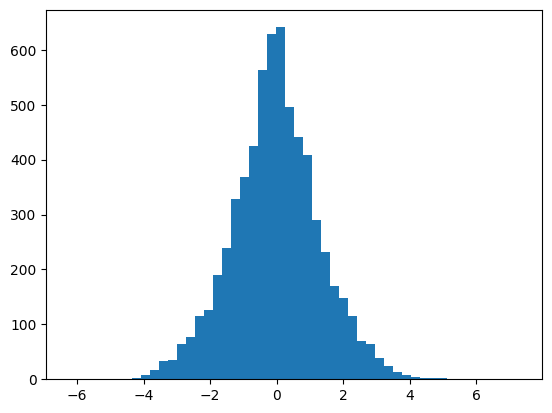

In [207]:
xs = torch.linspace(-15, 15, 1000)
# plt.axhline(200, linestyle="--")
# plt.plot(xs, 200 + torch.tanh(xs) * 200)
plt.hist(rearrange(hpreact, "n a -> (n a)").tolist(), 50);
plt.show()

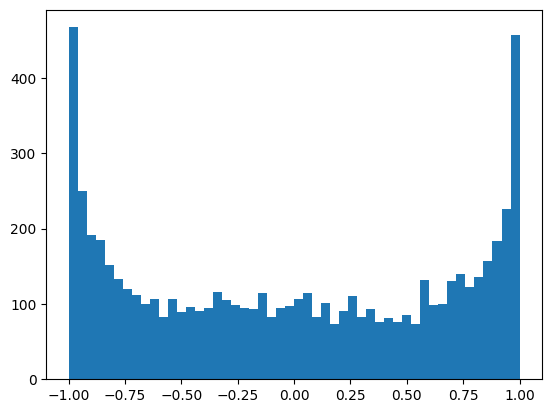

In [208]:
plt.hist(rearrange(h, "n a -> (n a)").tolist(), 50);

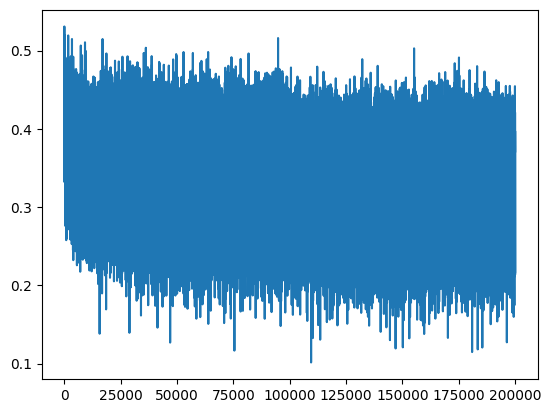

In [209]:
plt.plot(lossi);

In [210]:
# calibrate the batch norm at the end of the training

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [211]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0671908855438232
val 2.106106996536255


In [218]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])]
      embcat = rearrange(emb, "ix c f -> ix (c f)")
      hpreact = embcat @ W1 # + b1
      hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word



carlah.
amorie.
khi.
mri.
reity.
salaysie.
mahnen.
delynn.
jareei.
ner.
kiah.
maiivia.
leigh.
ham.
joce.
quint.
salin.
alianni.
wate.
madiaryn.
